In [202]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [10]:
fns = glob.glob('calc/*/energies.csv')

In [14]:
def read_file(fn):
    molid = fn.split('/')[1].strip('0')
    df = pd.read_csv(fn)
    df['molid'] = int(molid)
    df = df[~np.isnan(df.reference_energy)] # no missing reference values
    df = df[~df.targets.str.contains('He')] # no He in sites
    df = df[df.total_energy != df.reference_energy] # no identity operation
    return df.copy()
dfs = [read_file(_) for _ in fns]

In [21]:
df = pd.concat(dfs).reset_index(drop=True)

In [27]:
df.groupby('molid').count()['targets'].reset_index().sort_values('targets').tail()

,molid,targets
525,60128,16
877,113927,17
793,101717,17
854,110138,18
905,118466,20


In [53]:
df.query('molid == 92').sort_values('reference_energy').rank()

,targets,total_energy,reference_energy,molid
6103,10.0,1.0,1.0,6.0
6101,8.0,2.0,2.0,6.0
6102,9.0,4.0,3.0,6.0
6100,7.0,3.0,4.0,6.0
6097,4.0,9.0,5.0,6.0
6099,6.0,6.0,6.0,6.0
6098,5.0,7.0,7.0,6.0
6104,11.0,5.0,8.0,6.0
6095,2.0,8.0,9.0,6.0
6094,1.0,10.0,10.0,6.0


In [97]:
def analyse_rank(targetrank):
    molids = []
    poss = []
    for name, group in df.groupby('molid'):
        try:
            poss.append(np.where(group.sort_values('reference_energy').rank(numeric_only=True, method='first')['total_energy'].values == targetrank)[0][0]+1)
            molids.append(name)
        except:
            pass
    return molids, poss
def rank_everything(df):
    dfs = []
    for name, group in df.groupby('molid'):
        s = group.sort_values('reference_energy').rank(numeric_only=True, method='first')
        s.columns = 'total_rank reference_rank molid'.split()
        s.molid = name
        dfs.append(s.copy())
    return pd.concat(dfs)
        

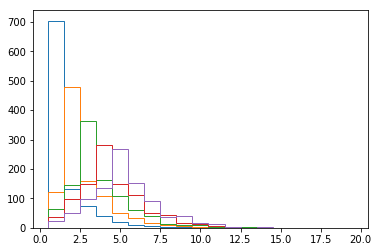

In [134]:
for targetrank in (1, 2, 3, 4, 5):
    molids, poss = analyse_rank(targetrank)
    bins = np.linspace(1, max(poss)+1, max(poss)+1)-0.5
    plt.hist(poss, bins=bins, histtype='step')

In [98]:
df_rank = rank_everything(df)

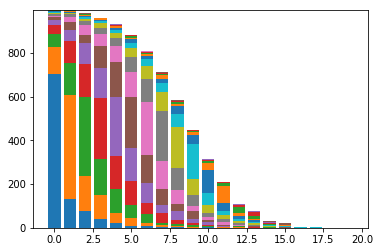

In [133]:
base = np.zeros(20)
for target_rank in sorted(df_rank.total_rank.unique()):
    thisvector = np.zeros(base.shape)
    s = df_rank.query('total_rank == @target_rank').groupby('reference_rank').count().reset_index()
    thisvector[s.reference_rank.values.astype(np.int)-1] = s.total_rank.values
    plt.bar(range(base.shape[0]), thisvector, bottom=base)
    base += thisvector

In [143]:
def find_correct_ones(real_position, max_deviation=0):
    total = df_rank.query('reference_rank == @real_position')
    match = total.query('abs(total_rank - reference_rank) <= @max_deviation')
    return len(match) / len(total)

Text(0, 0.5, '% correctly assigned\n from APDFT')

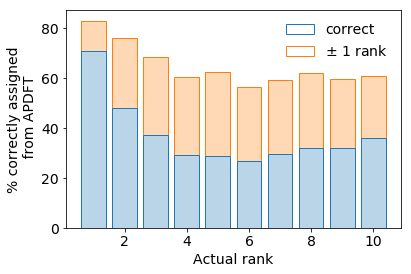

In [199]:
plt.rc('font', size=14)
xs = range(1, 11)
base = np.zeros(len(xs))
labels = {0: 'correct', 1:r'$\pm$ 1 rank',2:r'$\pm$ 2 rank'}
for delta in (0, 1,):
    ys = [find_correct_ones(_, delta) for _ in xs]
    plt.bar(xs, np.array(ys)*100, bottom=base, zorder=-delta, color='white')
    plt.bar(xs, np.array(ys)*100, bottom=base, zorder=-delta, alpha=0.3, color='C%d' % delta)
    d = plt.bar(xs, np.array(ys)*100, bottom=base, zorder=-delta, label=labels[delta], edgecolor='C%d' % delta, color='none')
plt.legend(frameon=False)
plt.xlabel('Actual rank')
plt.ylabel('% correctly assigned\n from APDFT')

In [208]:
counts = {}
for name, group in df_rank.groupby('molid'):
    count = len(group)
    rank = sts.spearmanr(group.total_rank, group.reference_rank)
    if count not in counts:
        counts[count] = []
    counts[count].append(rank[0])

In [220]:
xs = []
ys = []
for nhydrogens in sorted(counts.keys()):
    xs.append(nhydrogens)
    ys.append(np.median(counts[nhydrogens]))

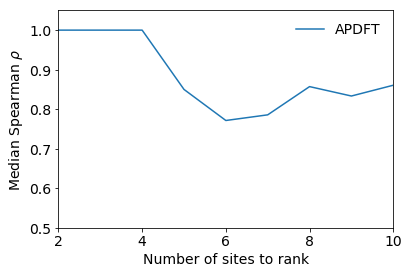

In [230]:
plt.plot(xs, ys, label='APDFT')
plt.xlim(2, 10)
plt.ylim(0.5, 1.05)
plt.xlabel('Number of sites to rank')
plt.ylabel(r'Median Spearman $\rho$')
plt.legend(frameon=False)